In [1]:
import os
import sys
import shutil
import argparse
import logging as logger
import re
import numpy as np
from tqdm import tqdm
import math
import random
import itertools
import cv2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

sys.path.insert(0, os.path.abspath('.'))
# from utils.model_loader import ModelLoader
from torch.utils.data import Dataset
from data.data_loader import ConvertRGB2BGR, FixedImageStandard
# from skimage import io, transform
import network.gccsa_net as net
from PIL import Image
from configs import config_ipynb as config
from data import data_loader
from configs.params import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.allow_tf32 = True

load_model_path = '../models/best_model/ideanet/CF_TL_11_1_4_4/MobileFaceNet_CF_S128.0_M0.35_A1.0_TL_ID-1_AP0.001_M1.0_K1_A10.0_DO0.3_BN1_M0.1_20230122_065421_zeke.pth' #best
# load_model_path = '../models/best_model/ideanet/CF_TL_11_1_4_4/MobileFaceNet_CF_S128.0_M0.35_A1.0_TL_ID-1_AP0.001_M1.0_K1_A10.0_DO0.3_BN1_M0.1_20230110_224553_zeke.pth' #mtl
face_model_path = '../models/best_model/MobileFaceNet_Restormer/10_0B1_7_4/MobileFaceNet_Restormer_S64.0_M0.35_1024_FaceBaseline_BN1_M0.1_20230208_220135_zeke.pth'
peri_model_path = '../models/best_model/MobileFaceNet_Restormer/01_0B1_7_4/MobileFaceNet_Restormer_S64.0_M0.35_1024_PeriBaseline_BN1_M0.1_20230208_220107_zeke.pth'

# load_model_path = '../models/best_model/MobileFaceNet/11_1_4_4/MobileFaceNet_S64.0_M0.35_1024_NewCLR_BN1_M0.1_20230207_203235_zeke.pth' #best
# # load_model_path = '../models/best_model/MobileFaceNet/11_1_4_4/MobileFaceNet_S64.0_M0.35_1024_BN1_M0.1_20230207_203354_zeke.pth' #mtl
# face_model_path = '../models/best_model/MobileFaceNet/10_0B1_7_4/MobileFaceNet_S64.0_M0.35_1024_FaceBaseline_BN1_M0.1_20230216_110040_zeke.pth'
# peri_model_path = '../models/best_model/MobileFaceNet/01_0B1_7_4/MobileFaceNet_S64.0_M0.35_1024_PeriBaseline_BN1_M0.1_20230215_150159_zeke.pth'
method = 'gccsa_best'
titles = ['GC$^2$SA-Net + $\mathcal{L}_{MACL}$', 'GC$^2$SA-Net', 'GC$^2$SA-Net (Baseline)', 'MobileFaceNet + $\mathcal{L}_{MACL}$', 'MobileFaceNet', 'MobileFaceNet (Baseline)']

In [2]:
def train(conf):
    data_trans = transforms.Compose( [ transforms.Resize((112,112)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
                                     # FixedImageStandard 
                                    ] )
    transform_test = transforms.Compose([   
                                            transforms.Resize((112,112)),
                                            ConvertRGB2BGR, transforms.ToTensor(), FixedImageStandard ])

    transform_test_peri = transforms.Compose([ 
                                            # transforms.Resize((37,112)),
                                            transforms.Resize((112,112)),
                                            ConvertRGB2BGR, transforms.ToTensor(), FixedImageStandard ])

    train_sourceset = datasets.ImageFolder(conf.data_root_source, transform = data_trans)
    train_targetset = datasets.ImageFolder(conf.data_root_target, transform = data_trans)

    data_loader_source = DataLoader(ImageDataset(conf.data_root_source, conf.train_file_source, transforms= data_trans), 
                             100, num_workers = 4,drop_last=False)
    data_loader_target = DataLoader(ImageDataset(conf.data_root_target, conf.train_file_target, transforms= data_trans), 
                             100, num_workers = 4,drop_last=False)
                             

    # -------------------------------------------- declare networks below -----------------------------------------------------------
    embd_dim = 1024

    model = net.MobileFaceNet(embedding_size = embd_dim, out_h = 7, out_w = 7, do_prob = 0.0).to(device)
    face_model = net.MobileFaceNet(embedding_size = embd_dim, out_h = 7, out_w = 7, do_prob = 0.0).to(device)
    peri_model = net.MobileFaceNet(embedding_size = embd_dim, out_h = 7, out_w = 7, do_prob = 0.0).to(device)
    # model = net.ResNetIR50(do_prob=0.4).eval().to(device)

    #--------------------------------------------- load the classifier trained -----------------------------------------------------------
    if conf.resume:
        model = load_model_fn(model, load_model_path, 'state_dict')
        face_model = load_model_fn(face_model, face_model_path, 'state_dict')
        peri_model = load_model_fn(peri_model, peri_model_path, 'state_dict')
        print()
        print("Loaded the trained embedding layer and classifier(s) well.")
    # -------------------------------------------- declaration of network end  ----------------------------------------------------------- 
    model.eval()
    face_model.eval()
    peri_model.eval()
    image_paths = None
    features_source, labelsS = get_features(data_loader_source, 
                model, conf, peri_flag=False)

    features_target, labelsT = get_features(data_loader_target, 
                model, conf, peri_flag=True)
    
    return features_source, features_target, labelsS, labelsT

class learnedweight(torch.nn.Module):
    def __init__(self):
        super(learnedweight, self).__init__()
        self.classifier_source_weight = Parameter(torch.ones(1), requires_grad=True)
        self.classifier_target_weight = Parameter(torch.ones(1), requires_grad=True)
    
    def forward(self, classifier_source_loss, classifier_target_loss):
        final_loss = self.classifier_source_weight + torch.exp(-1 * self.classifier_source_weight)*classifier_source_loss + \
                    self.classifier_target_weight + torch.exp(-1 * self.classifier_target_weight)*classifier_target_loss #+ \
                        # self.dc_weight + torch.exp(-1 * self.dc_weight)*dc_loss
                        # self.kd_weight + torch.exp(-1 * self.kd_weight)*kd_loss + \
 
        return final_loss

def plot_graph(mixed_ST):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    import cv2
    def convert_imgs(imgs):
        for i in range(imgs.shape[0]):
            # imgs[i] = imgs[i] #torch.from_numpy(cv2.cvtColor(imgs[i].cpu().detach().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB).transpose(2,0,1))
            imgs[i] = torch.from_numpy(cv2.cvtColor(imgs[i].cpu().detach().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB).transpose(2,0,1))
        return imgs

    # show_batch(mixed_query, 32)
    imgs = convert_imgs(mixed_ST)
    grid_img = make_grid(imgs, nrow=8).cpu().detach()
    fig=plt.figure()
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

class ImageDataset(Dataset):
    def __init__(self, data_root, train_file, transforms , crop_eye=False, if_flip=True):
        self.data_root = data_root
        self.train_list = []
        self.if_flip = if_flip
        train_file_buf = open(train_file)
        line = train_file_buf.readline().strip()
        self.transform = transforms
        while line:
            if " " in line:
                image_path, image_label = line.split(' ')
                self.train_list.append((image_path, int(image_label)))
                line = train_file_buf.readline().strip()
            else:
                image_path = line.split(' ')
                image_label = 'None'
                self.train_list.append((image_path, image_label))
                line = train_file_buf.readline().strip()
        self.crop_eye = crop_eye
        self.num_classes = sum([len(d) for r, d, folder in os.walk(data_root)])

    def __len__(self):
        return len(self.train_list)
    def __getitem__(self, index):
        image_path, image_label = self.train_list[index]
        image_path = os.path.join(self.data_root, image_path)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, image_label

class FaceModel(torch.nn.Module):
    """Define a traditional face model which contains a backbone and a head.
    
    Attributes:
        backbone(object): the backbone of face model.
        head(object): the head of face model.
    """
    def __init__(self, backbone_factory, head_factory, feat_dim):
        """Init face model by backbone factorcy and head factory.
        
        Args:
            backbone_factory(object): produce a backbone according to config files.
            head_factory(object): produce a head according to config files.
        """
        super(FaceModel, self).__init__()
        self.backbone = backbone_factory

    def forward(self, data, labelsS=None, labelsT=None):
        features = self.backbone.forward(data)
        return features
    
    def forward_feat(self, data, label):
        featvec = self.backbone.forward(data)
        # featmap = self.backbone.forward_feature_map(data)
        # featmap = self.attn(featmap)
        # featvec = self.backbone.forward_feature_vec_no_l2(featmap)        
        return featvec

def get_features(data_loader, model, conf, peri_flag):
    """Train one epoch by traditional training."""
    correct = 0
    total = 0

    # we'll store the features as NumPy array of size num_images x feature_size
    features = None

    # we'll also store the image labels and paths to visualize them later
    labels = []
    # image_paths = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Running the model inference'):
            images = batch[0].to(device)
            labels += batch[1].to(device)
            # image_paths += batch['image_path']
            # plot_graph(images)
            feat_outputs = model(images, peri_flag)
            current_features = feat_outputs.cpu().numpy()
            if features is not None:
                features = np.concatenate((features, current_features))
            else:
                features = current_features
    return features, labels #, image_paths

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image

def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

def visualize_tsne(tsne, images, labels, colors_per_class, marker_per_class, plot_size=1000, max_image_size=100, visualization='per_domain_visual'):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    # # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, labels,colors_per_class, marker_per_class, visualization)

    # visualize the plot: samples as images
    # visualize_tsne_images(tx, ty, images, labels, plot_size=plot_size, max_image_size=max_image_size)

def load_model_fn(model, load_model_path, key):
    state_dict_loaded = model.state_dict()
    state_dict_pretrained = torch.load(load_model_path, map_location=device)
    state_dict_temp = {}
    for k in state_dict_loaded:
        if 'backbone' in k:
            kk = k.replace('backbone.','')
        else:
            kk = k
            state_dict_temp[k] = state_dict_pretrained[kk] 
    state_dict_loaded.update(state_dict_temp)
    model.load_state_dict(state_dict_loaded)
    return model 

def visualize_tsne_points(tx, ty, labels, colors_per_class, marker_per_class, visualization):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams.update({'font.size': 20, 'legend.fontsize': 17})    
    # initialize matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(20, 15)
    ax2 = ax.twiny()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    color_list = []
    marker_list = []
    color = None
    marker = None
    # for every class, we'll add a scatter plot separately
    for label_num in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label_num]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)   

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color_first = np.array([colors_per_class[label_num][::-1]], dtype=float) / 255
        marker_first = marker_per_class[label_num]
        if not (color_first==color).all():
            color_list.append(color_first)
            color = color_first
        if not (marker_first==marker):
            marker_list.append(marker_first)
            marker = marker_first
        # add a scatter plot with the correponding color and label
        if visualization == "per_domain_visual":
            ax.scatter(current_tx, current_ty, c=color, marker=marker_per_class[label_num], s=300, alpha=0.35, edgecolors='grey')

        if visualization == "per_class_visual":
            ax.scatter(current_tx, current_ty, c=color, label=str(label_num + 1), marker=marker_per_class[label_num],s=200, alpha=0.95, edgecolors='grey')
            # ax.scatter(current_tx, current_ty, c=color, label=str(label_num+1), marker=marker_per_class[label_num], s=300, alpha=0.95, edgecolors='grey') if label_num > 9 else \
            # ax2.scatter(current_tx, current_ty, c=color, label=str(label_num+1), marker=marker_per_class[label_num], s=300, alpha=0.95, edgecolors='grey')               
    
    if visualization == "per_domain_visual":
        for idx, area in enumerate(['Face', 'Periocular']):
            plt.scatter([], [], c=color_list[idx], alpha=1, label=area, marker=marker_list[idx])
        lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=1, prop={'size': 16}, numpoints=5) #    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Labels', prop={'size': 12})
        lgnd.legendHandles[0]._sizes = [250]
        lgnd.legendHandles[1]._sizes = [250]
        # plt.legend(handles = [plt.plot([],ls="-", color=line.get_color())[0]],
        #    labels=[line.get_label()])
    elif visualization == "per_class_visual":
        # build a legend using the labels we set previously
        # ax.legend(loc='upper right', title = 'Face', framealpha=1.0)
        from matplotlib.lines import Line2D

        legend_elements_face = []
        legend_elements_peri = []
        for i in range (0, 20):
            if i > 9:
                legend_elements_face.append(Line2D([0], [0], marker='*', color=color_list[i], label=str(i + 1 - 10), markersize=15, alpha=0.95, linestyle='None'))
            else:
                legend_elements_peri.append(Line2D([0], [0], marker='o', color=color_list[i], label=str(i + 1), markersize=15, alpha=0.95, linestyle='None'))
        ax.legend(handles=legend_elements_face, loc='upper right', title='Face')
        ax2.legend(handles=legend_elements_peri, loc='upper left', title='Periocular')
    # finally, show the plot
    plt.title('GC$^2$SA-Net + $\mathcal{L}_{MACL}$')
    plt.show()
    fig.savefig(image_paths, bbox_inches='tight')

if __name__ == '__main__': 
    conf = argparse.ArgumentParser(description='traditional_training for face recognition.')
    conf.add_argument('--gpu_id', type=str, nargs='?', default='1', help="device id to run")
    #confusion net
    conf.add_argument('--random', type=bool, default=True, help="whether use random projection")
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # TSNE Load Data
    conf.add_argument("--data_root_source", type = str, default= '/home/tiongsik/Python/ideanet_cb/data/tsne/training/face',
                      help = "The root folder of source training set.")
    conf.add_argument("--train_file_source", type = str, default='/home/tiongsik/Python/ideanet_cb/data/tsne/img_lists/training_face.txt', 
                      help = "The source training file path.")
    conf.add_argument("--data_root_target", type = str, default= '/home/tiongsik/Python/ideanet_cb/data/tsne/training/peri',
                      help = "The root folder of target training set.")
    conf.add_argument("--train_file_target", type = str, default='/home/tiongsik/Python/ideanet_cb/data/tsne/img_lists/training_peri.txt', 
                      help = "The target training file path.")                            
    
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    conf.add_argument("--backbone_type", type = str, default = 'MobileFaceNet',
                      help = "Mobilefacenets, Resnet.")
    conf.add_argument('--resume', '-r', action = 'store_true', default = True, 
                      help = 'Whether to resume from a checkpoint.')

    args = conf.parse_args(args=[])
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id
    
    logger.info('Start optimization.')
    logger.info(args)
    output = train(args)
    logger.info('Optimization done!')




Loaded the trained embedding layer and classifier(s) well.


Running the model inference: 100%|██████████| 17/17 [00:00<00:00, 20.81it/s]


In [3]:
load_source_fc_path = load_model_path.replace('best_model', 'best_face_fc')
load_target_fc_path = load_model_path.replace('best_model', 'best_peri_fc')
source_fc = torch.load(load_source_fc_path, map_location=device)
target_fc = torch.load(load_target_fc_path, map_location=device)

# prototype
source_pts = source_fc['weight']
target_pts = target_fc['weight']

# Face images
face_train_dir = config.trainingdb['face_train']
face_loader_train, face_train_set = data_loader.gen_data(face_train_dir, 'train', type='face', aug='False')
# Periocular Images
peri_train_dir = config.trainingdb['peri_train']
peri_loader_train, peri_train_set = data_loader.gen_data(peri_train_dir, 'train', type='face', aug='False')

label_dict = {}
for index, label in enumerate(peri_train_set.classes):
    label_dict[label] = index

In [4]:
import csv
file_list_dict = {}
train_file_buf = args.train_file_source
with open(train_file_buf, 'r') as csvfile:
    lines = list(csv.reader(csvfile, delimiter='\t'))[1:]
for line in lines:
    index = (line[0].split(' ')[-1])
    label = (line[0].split('/')[-2])
    file_list_dict[label] = index

source_toy_prototype = torch.Tensor([]).to(device)
target_toy_prototype = torch.Tensor([]).to(device)
for i in file_list_dict:
    # print(label_dict[i])
    source_toy_prototype = torch.cat((source_toy_prototype, source_pts[label_dict[i]].unsqueeze(dim=0).to(device)), dim=0)
    target_toy_prototype = torch.cat((target_toy_prototype, target_pts[label_dict[i]].unsqueeze(dim=0).to(device)), dim=0)

source_toy_prototype = F.normalize(source_toy_prototype, p=2, dim=1)
target_toy_prototype = F.normalize(target_toy_prototype, p=2, dim=1)

In [5]:
features_source, features_target, labelsS, labelsT = output
features = np.concatenate((features_source, features_target, source_toy_prototype.cpu().numpy(), target_toy_prototype.cpu().numpy()),axis=0)
labels = np.concatenate((torch.Tensor(labelsS).cpu().numpy(), torch.Tensor(labelsT).cpu().numpy()+10, torch.Tensor(torch.range(20, 29, 1)), torch.Tensor(torch.range(30, 39, 1))),axis=0)
tsne = TSNE(n_components=2).fit_transform(features)

# features_source, features_target, labelsS, labelsT = output
# features = np.concatenate((features_source, features_target),axis=0)
# labels = np.concatenate((torch.Tensor(labelsS).cpu().numpy(), torch.Tensor(labelsT).cpu().numpy()+10),axis=0)
# tsne = TSNE(n_components=2, random_state=seed).fit_transform(features)

/tmp/ipykernel_641484/76569113.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  labels = np.concatenate((torch.Tensor(labelsS).cpu().numpy(), torch.Tensor(labelsT).cpu().numpy()+10, torch.Tensor(torch.range(20, 29, 1)), torch.Tensor(torch.range(30, 39, 1))),axis=0)


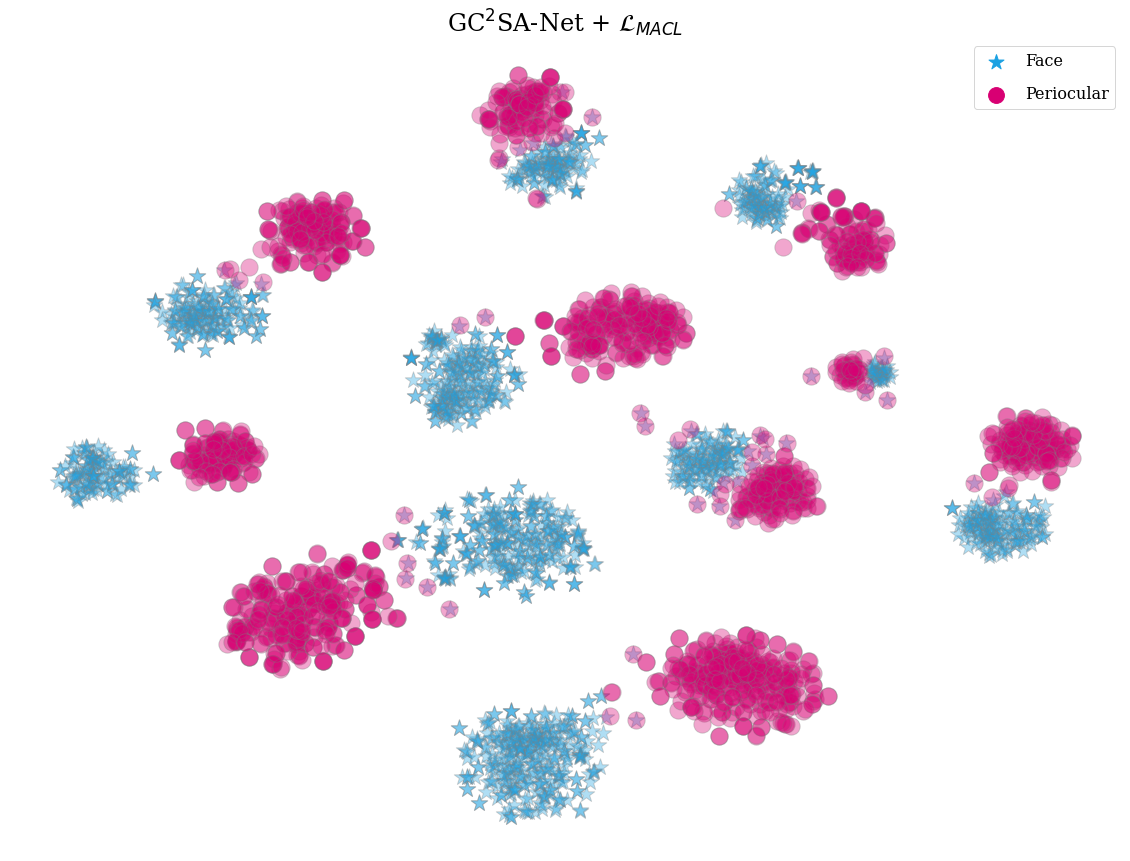

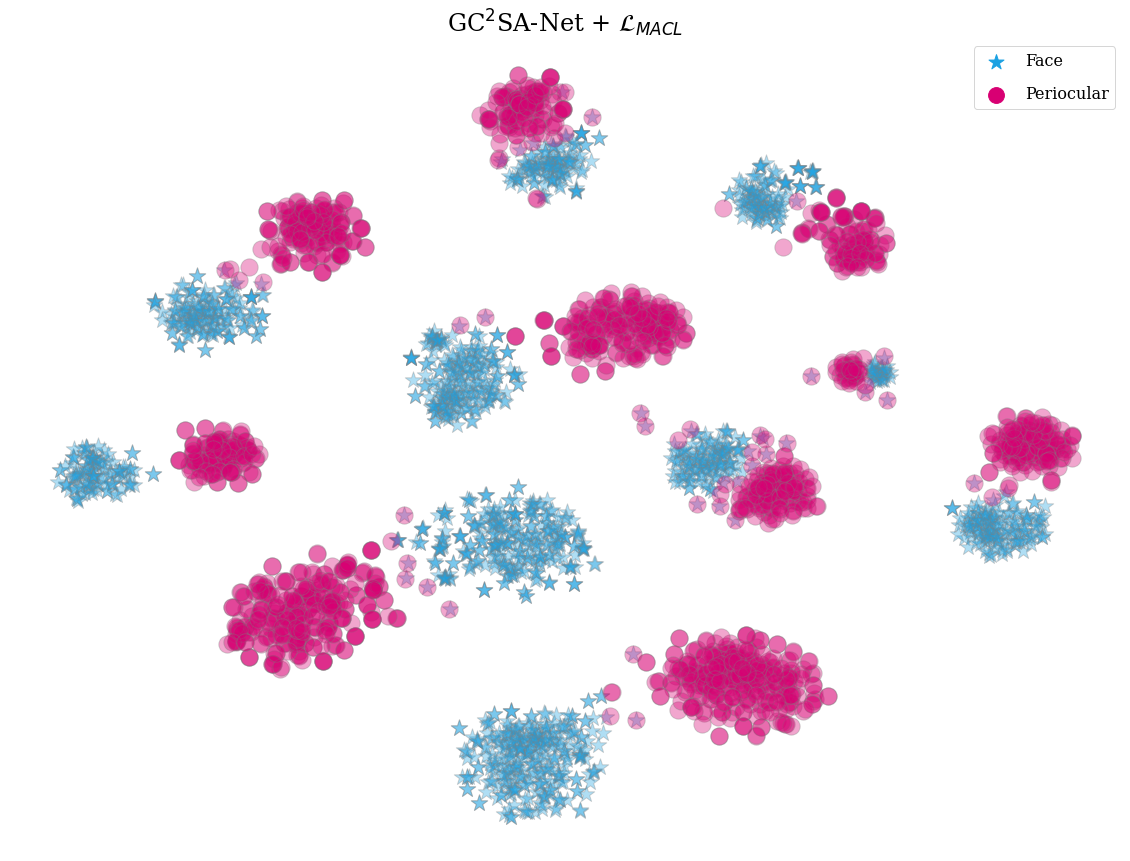

In [8]:
colors_per_class = {
    0 : [226, 161, 27], #blue HR
    1 : [226, 161, 27],
    2 : [226, 161, 27],
    3 : [226, 161, 27],
    4 : [226, 161, 27],
    5 : [226, 161, 27],
    5 : [226, 161, 27],
    6 : [226, 161, 27],
    7 : [226, 161, 27],
    8 : [226, 161, 27],
    9 : [226, 161, 27],
    10: [115,  0, 216],
    11: [115,  0, 216],  #orange LR
    12: [115,  0, 216],
    13: [115,  0, 216],
    14: [115,  0, 216],
    15: [115,  0, 216],
    16: [115,  0, 216],
    17: [115,  0, 216],
    18: [115,  0, 216],
    19: [115,  0, 216],
    20: [0, 0, 0],
    21: [0, 0, 0],
    22: [0, 0, 0],
    23: [0, 0, 0],
    24: [0, 0, 0],
    25: [0, 0, 0],
    26: [0, 0, 0],
    27: [0, 0, 0],
    28: [0, 0, 0],
    29: [0, 0, 0],
    
    30: [0, 0, 0],
    31: [0, 0, 0],
    32: [0, 0, 0],
    33: [0, 0, 0],
    34: [0, 0, 0],
    35: [0, 0, 0],
    36: [0, 0, 0],
    37: [0, 0, 0],
    38: [0, 0, 0],
    39: [0, 0, 0],

    }

marker_per_class = {   
    0 : "*",  
    1 : "*",  
    2 : "*",
    3 : "*",
    4 : "*",
    5 : "*",
    6 : "*",
    7 : "*",
    8 : "*",
    9 : "*",

    10: "o",
    11: "o",
    12: "o",
    13: "o",
    14: "o",
    15: "o",
    16: "o",
    17: "o",
    18: "o",
    19: "o",

    20: "D",
    21: "D",
    22: "D",
    23: "D",
    24: "D",
    25: "D",
    26: "D",
    27: "D",
    28: "D",
    29: "D",

    30: "o",
    31: "o",
    32: "o",
    33: "o",
    34: "o",
    35: "o",
    36: "o",
    37: "o",
    38: "o",
    39: "o",
    }
# for creating a responsive plot
image_paths = '/home/tiongsik/PycharmProjects/ideanet_cb/graphs/tsne/' + str(method) + '_peri_face_sep.pdf'
visualize_tsne(tsne, image_paths, labels, colors_per_class, marker_per_class, visualization="per_domain_visual")
image_paths = '/home/tiongsik/PycharmProjects/ideanet_cb/graphs/tsne/' + str(method) + '_peri_face_sep.svg'
visualize_tsne(tsne, image_paths, labels, colors_per_class, marker_per_class, visualization="per_domain_visual")

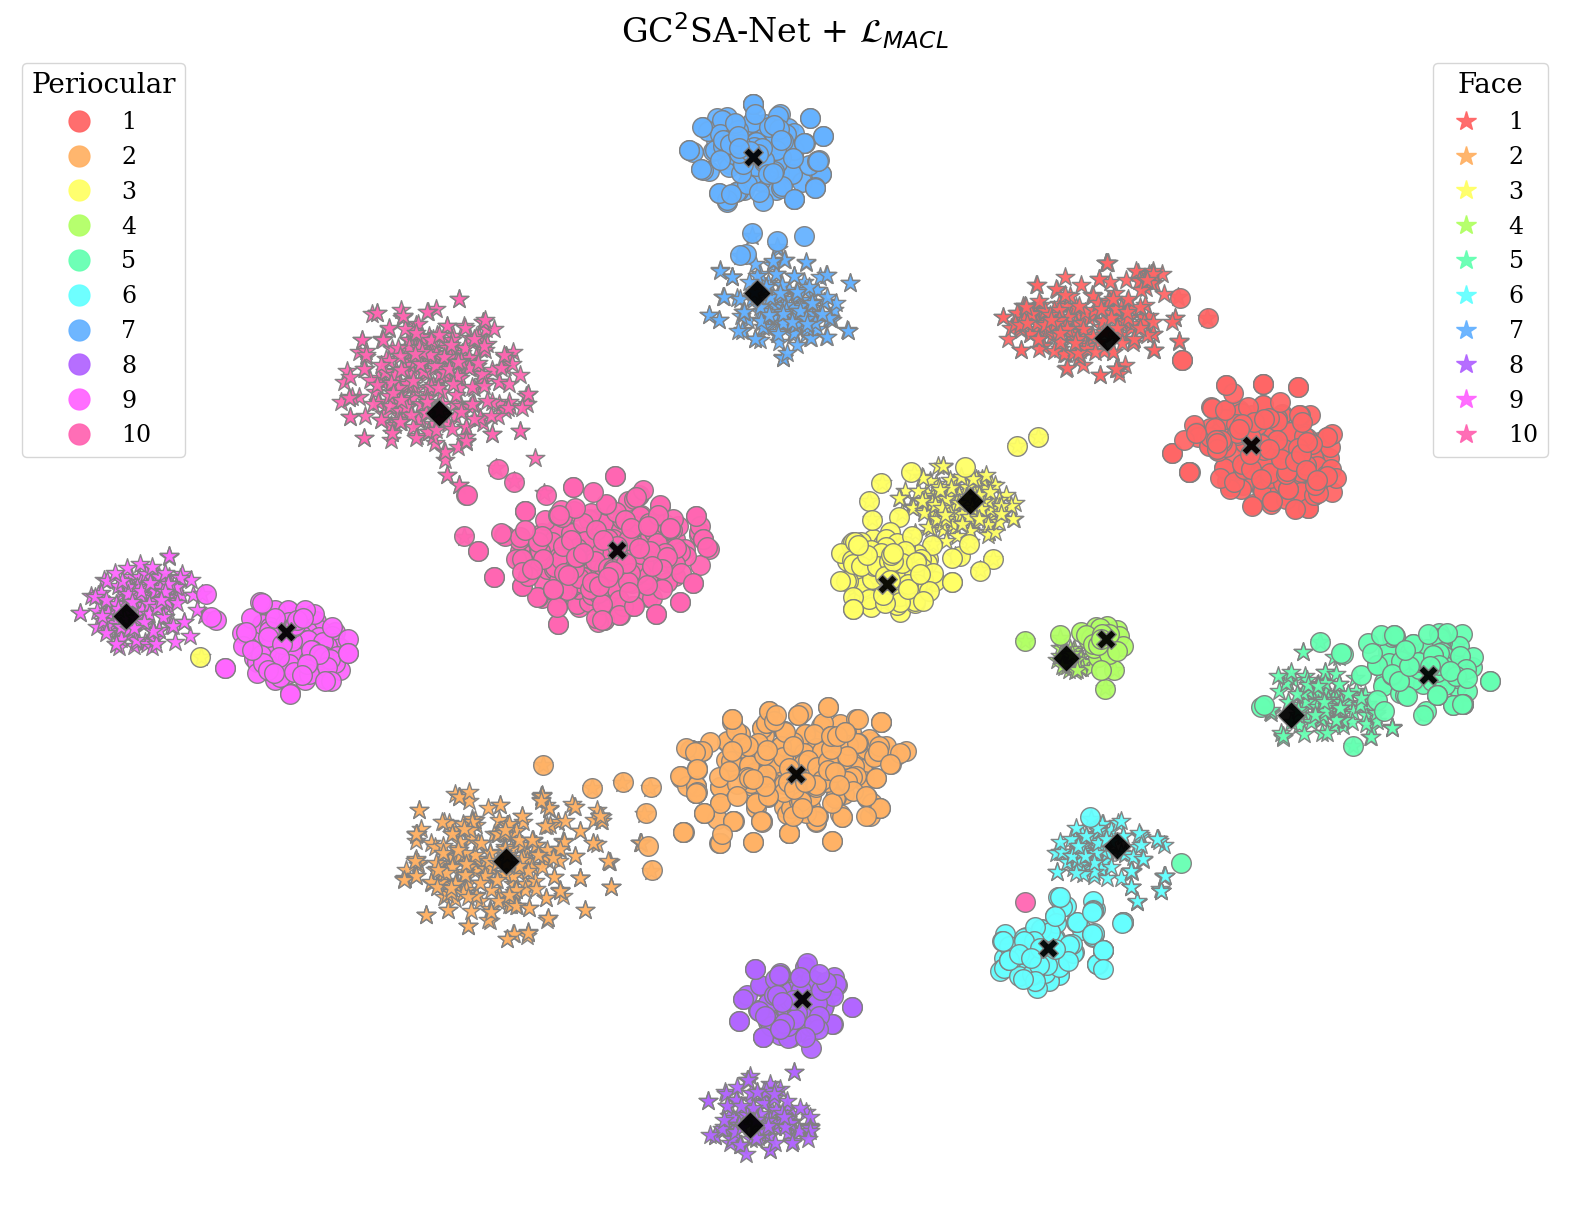

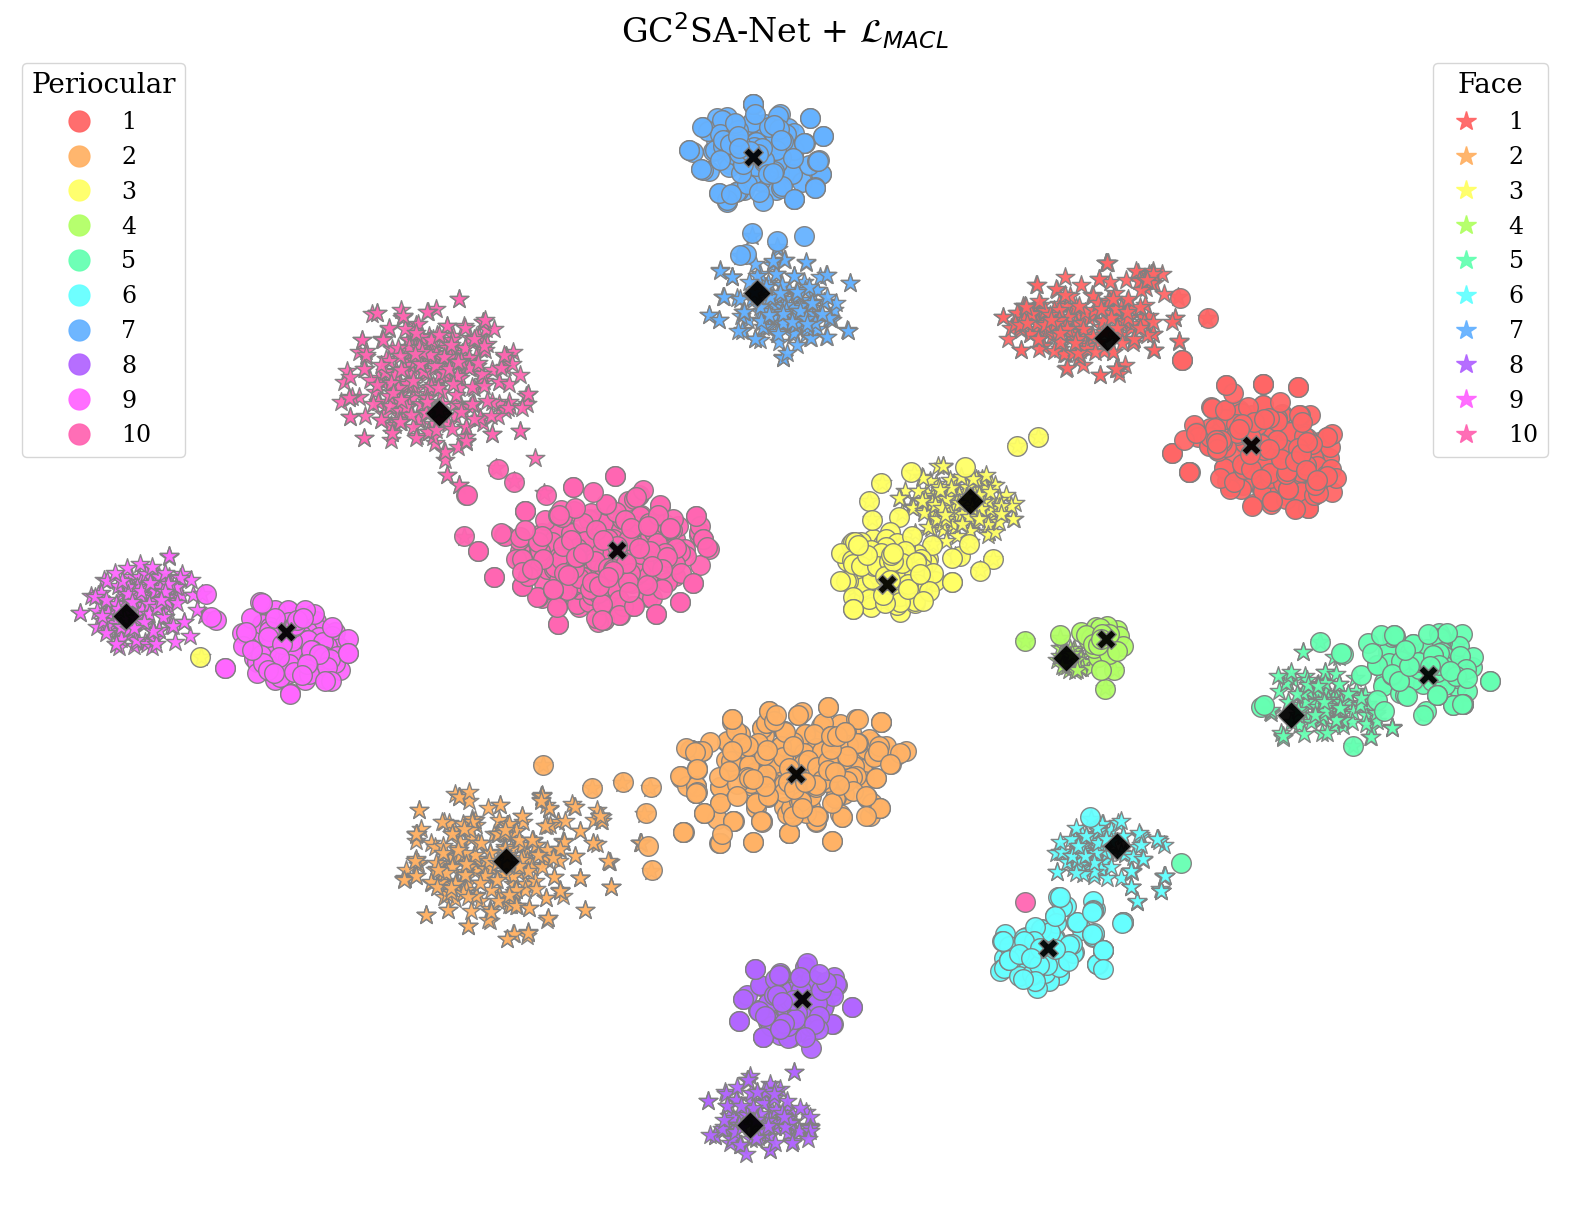

In [7]:
# colors_per_class = {   # B, G, R
    # 0 : [0, 0, 153],  #red
    # 1 : [0,76,153],   #orange,brown
    # 2 : [0,153,153],   #yellow
    # 3 : [0,153,76],   #olive
    # 4 : [76,153,0],        #green
    # 5 : [153,153,0],     #cyan
    # 6 : [204,102,0],    #blue
    # 7 : [204,0,102],    #purple
    # 8 : [204,0,204],  #pink
    # 9 : [76,0,153],   #rose
    # # 10 : [64,64,64],  #grey
    # 10: [102,102,255],
    # 11: [102,178,255],
    # 12: [102,255,255],
    # 13: [102,255,178],
    # 14: [178,255,102],
    # 15: [255,255,102],
    # 16: [255,178,102],
    # 17: [255,102,178],
    # 18: [255,102,255],
    # 19: [178,102,255],
    # # 21: [192,192,192]
    # 20: [102,102,255],
    # 21: [102,178,255],
    # 22: [102,255,255],
    # 23: [102,255,178],
    # 24: [178,255,102],
    # 25: [255,255,102],
    # 26: [255,178,102],
    # 27: [255,102,178],
    # 28: [255,102,255],
    # 29: [178,102,255],
	# 30: [102,102,255],
    # 31: [102,178,255],
    # 32: [102,255,255],
    # 33: [102,255,178],
    # 34: [178,255,102],
    # 35: [255,255,102],
    # 36: [255,178,102],
    # 37: [255,102,178],
    # 38: [255,102,255],
    # 39: [178,102,255],
    # }

colors_per_class = {   # B, G, R
    0: [102,102,255],
    1: [102,178,255],
    2: [102,255,255],
    3: [102,255,178],
    4: [178,255,102],
    5: [255,255,102],
    6: [255,178,102],
    7: [255,102,178],
    8: [255,102,255],
    9: [178,102,255],

    10: [102,102,255],
    11: [102,178,255],
    12: [102,255,255],
    13: [102,255,178],
    14: [178,255,102],
    15: [255,255,102],
    16: [255,178,102],
    17: [255,102,178],
    18: [255,102,255],
    19: [178,102,255],
    
    20: [0, 0, 0],
    21: [0, 0, 0],
    22: [0, 0, 0],
    23: [0, 0, 0],
    24: [0, 0, 0],
    25: [0, 0, 0],
    26: [0, 0, 0],
    27: [0, 0, 0],
    28: [0, 0, 0],
    29: [0, 0, 0],

    30: [0, 0, 0],
    31: [0, 0, 0],
    32: [0, 0, 0],
    33: [0, 0, 0],
    34: [0, 0, 0],
    35: [0, 0, 0],
    36: [0, 0, 0],
    37: [0, 0, 0],
    38: [0, 0, 0],
    39: [0, 0, 0],
    
    # 30: [102,102,255],
    # 31: [102,178,255],
    # 32: [102,255,255],
    # 33: [102,255,178],
    # 34: [178,255,102],
    # 35: [255,255,102],
    # 36: [255,178,102],
    # 37: [255,102,178],
    # 38: [255,102,255],
    # 39: [178,102,255],
    }

marker_per_class = {   
    0 : "*",  
    1 : "*",  
    2 : "*",
    3 : "*",
    4 : "*",
    5 : "*",
    6 : "*",
    7 : "*",
    8 : "*",
    9 : "*",

    10: "o",
    11: "o",
    12: "o",
    13: "o",
    14: "o",
    15: "o",
    16: "o",
    17: "o",
    18: "o",
    19: "o",

    20: "D",
    21: "D",
    22: "D",
    23: "D",
    24: "D",
    25: "D",
    26: "D",
    27: "D",
    28: "D",
    29: "D",

    30: "X",
    31: "X",
    32: "X",
    33: "X",
    34: "X",
    35: "X",
    36: "X",
    37: "X",
    38: "X",
    39: "X",
    }

image_paths = '/home/tiongsik/Python/ideanet_cb/graphs/tsne/' + str(method) + '_peri_face_class_sep11.pdf'
visualize_tsne(tsne, image_paths, labels, colors_per_class, marker_per_class, visualization="per_class_visual")
image_paths = '/home/tiongsik/Python/ideanet_cb/graphs/tsne/' + str(method) + '_peri_face_class_sep11.svg'
visualize_tsne(tsne, image_paths, labels, colors_per_class, marker_per_class, visualization="per_class_visual")

In [16]:
a

NameError: name 'a' is not defined

# Plot 3D

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_tsne_points(tx, ty, tz, labels, colors_per_class, marker_per_class, visualization):
    # initialize matplotlib plot
    fig = plt.figure()
    ax = Axes3D(fig) #fig.add_subplot(111,projection='3d')
    fig.set_size_inches(20, 15)
    
    color_list = []
    marker_list = []
    color = None
    marker = None
    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)   
        current_tz = np.take(tz, indices)   

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color_first = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255
        marker_first = marker_per_class[label]
        if not (color_first==color).all():
            color_list.append(color_first)
            color = color_first
        if not (marker_first==marker):
            marker_list.append(marker_first)
            marker = marker_first
        # add a scatter plot with the correponding color and label
        if visualization == "per_domain_visual":
            ax.scatter(current_tx, current_ty, current_tz, c=color, marker=marker_per_class[label], s=300, alpha=0.35, edgecolors='grey')
        elif visualization == "per_class_visual":
            ax.scatter(current_tx, current_ty, current_tz, c=color, label=label, marker=marker_per_class[label],s=200, alpha=0.95, edgecolors='grey')
    
    if visualization == "per_domain_visual":
        for idx, area in enumerate(['Face', 'Peri']):
            plt.scatter([], [], [], c=color_list[idx], alpha=1, label=area, marker=marker_list[idx])
        lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=1, prop={'size': 16}, numpoints=5) #    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Labels', prop={'size': 12})
        lgnd.legendHandles[0]._sizes = [250]
        lgnd.legendHandles[1]._sizes = [250]
        # plt.legend(handles = [plt.plot([],ls="-", color=line.get_color())[0]],
        #    labels=[line.get_label()])
    elif visualization == "per_class_visual":
        # build a legend using the labels we set previously
        ax.legend(loc='best')

    # finally, show the plot
    plt.show()
    fig.savefig(image_paths)

def visualize_tsne(tsne, images, labels, colors_per_class, marker_per_class, plot_size=1000, max_image_size=100, visualization='per_domain_visual'):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tz = tsne[:, 2]


    # # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    tz = scale_to_01_range(tz)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, tz, labels,colors_per_class, marker_per_class, visualization)

    # visualize the plot: samples as images
    # visualize_tsne_images(tx, ty, images, labels, plot_size=plot_size, max_image_size=max_image_size)

/home/tiongsik/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tiongsik/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_1135/423444380.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #fig.add_subplot(111,projection='3d')
/tmp/ipykernel_1135/423444380.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. 

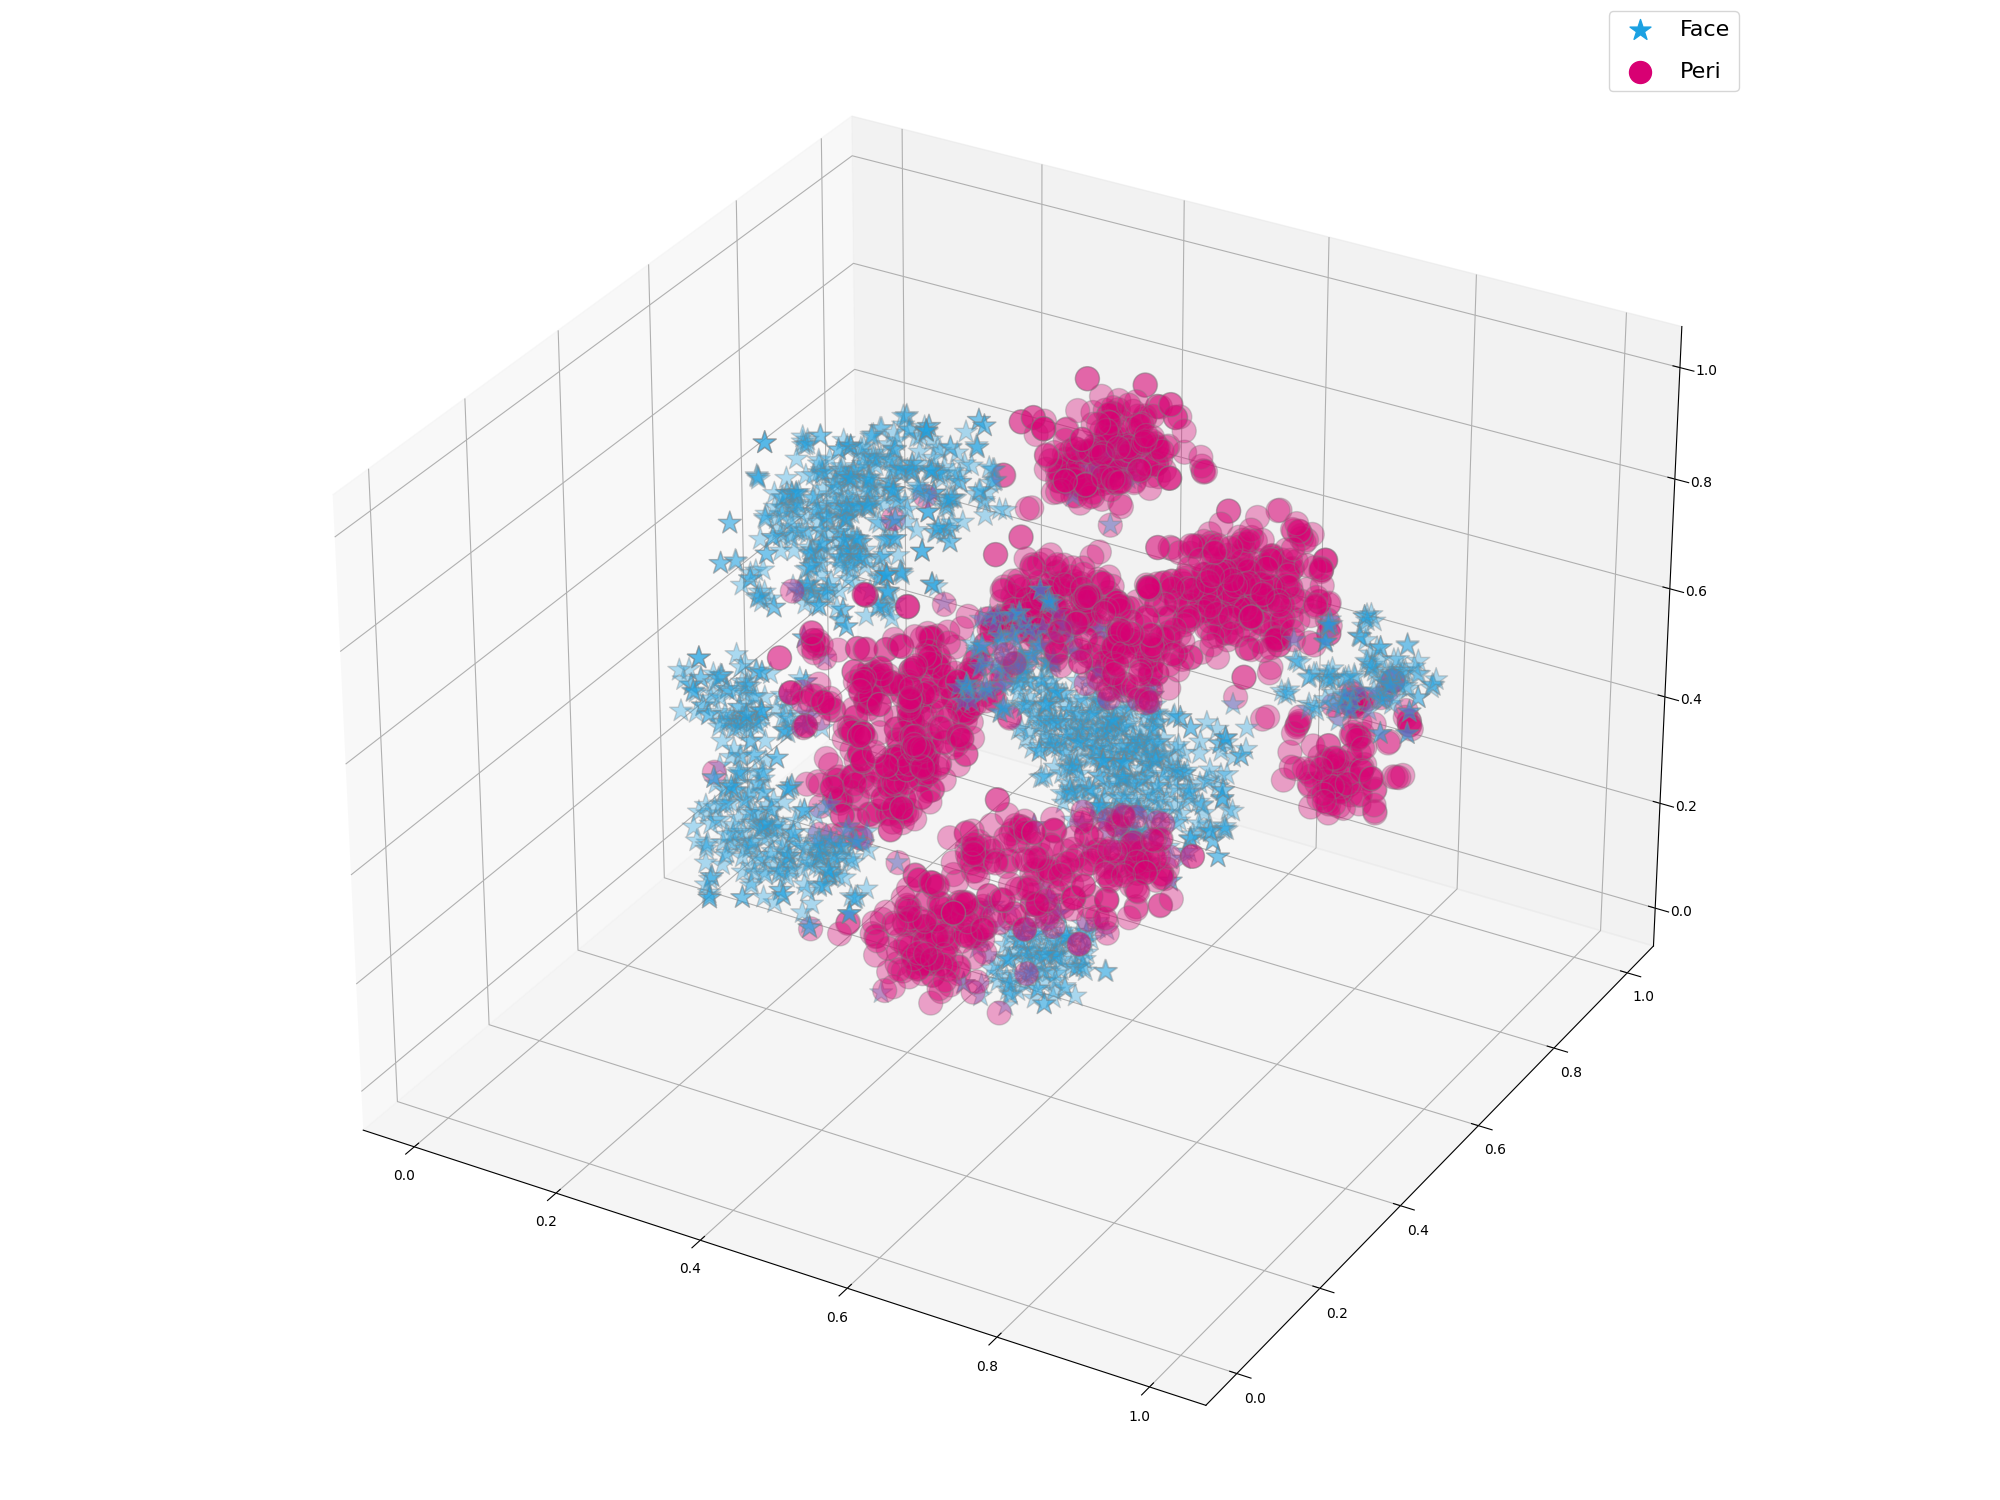

In [ ]:
colors_per_class = {
    0 : [226, 161, 27], #blue HR
    1 : [226, 161, 27],
    2 : [226, 161, 27],
    3 : [226, 161, 27],
    4 : [226, 161, 27],
    5 : [226, 161, 27],
    5 : [226, 161, 27],
    6 : [226, 161, 27],
    7 : [226, 161, 27],
    8 : [226, 161, 27],
    9 : [226, 161, 27],
    10: [115,  0, 216],
    11: [115,  0, 216],  #orange LR
    12: [115,  0, 216],
    13: [115,  0, 216],
    14: [115,  0, 216],
    15: [115,  0, 216],
    16: [115,  0, 216],
    17: [115,  0, 216],
    18: [115,  0, 216],
    19: [115,  0, 216],
    # 20: [115,  0, 216],
    # 21: [115,  0, 216]
    }

marker_per_class = {   
    0 : "*",  
    1 : "*",  
    2 : "*",
    3 : "*",
    4 : "*",
    5 : "*",
    6 : "*",
    7 : "*",
    8 : "*",
    9 : "*",

    10: "o",
    11: "o",
    12: "o",
    13: "o",
    14: "o",
    15: "o",
    16: "o",
    17: "o",
    18: "o",
    19: "o",
    # 20: "o",
    # 21: "o",
    }
# for creating a responsive plot
%matplotlib widget
features_source, features_target, labelsS, labelsT = output
features = np.concatenate((features_source,features_target),axis=0)
labels = np.concatenate((torch.Tensor(labelsS).cpu().numpy(),torch.Tensor(labelsT).cpu().numpy()+10),axis=0)
tsne = TSNE(n_components=3).fit_transform(features)
image_paths = '/home/tiongsik/PycharmProjects/ideanet_cb/graphs/tsne/baseline_peri.svg'
visualize_tsne(tsne, image_paths, labels, colors_per_class, marker_per_class, visualization="per_domain_visual")

/tmp/ipykernel_1135/423444380.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #fig.add_subplot(111,projection='3d')
/tmp/ipykernel_1135/423444380.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_first = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255


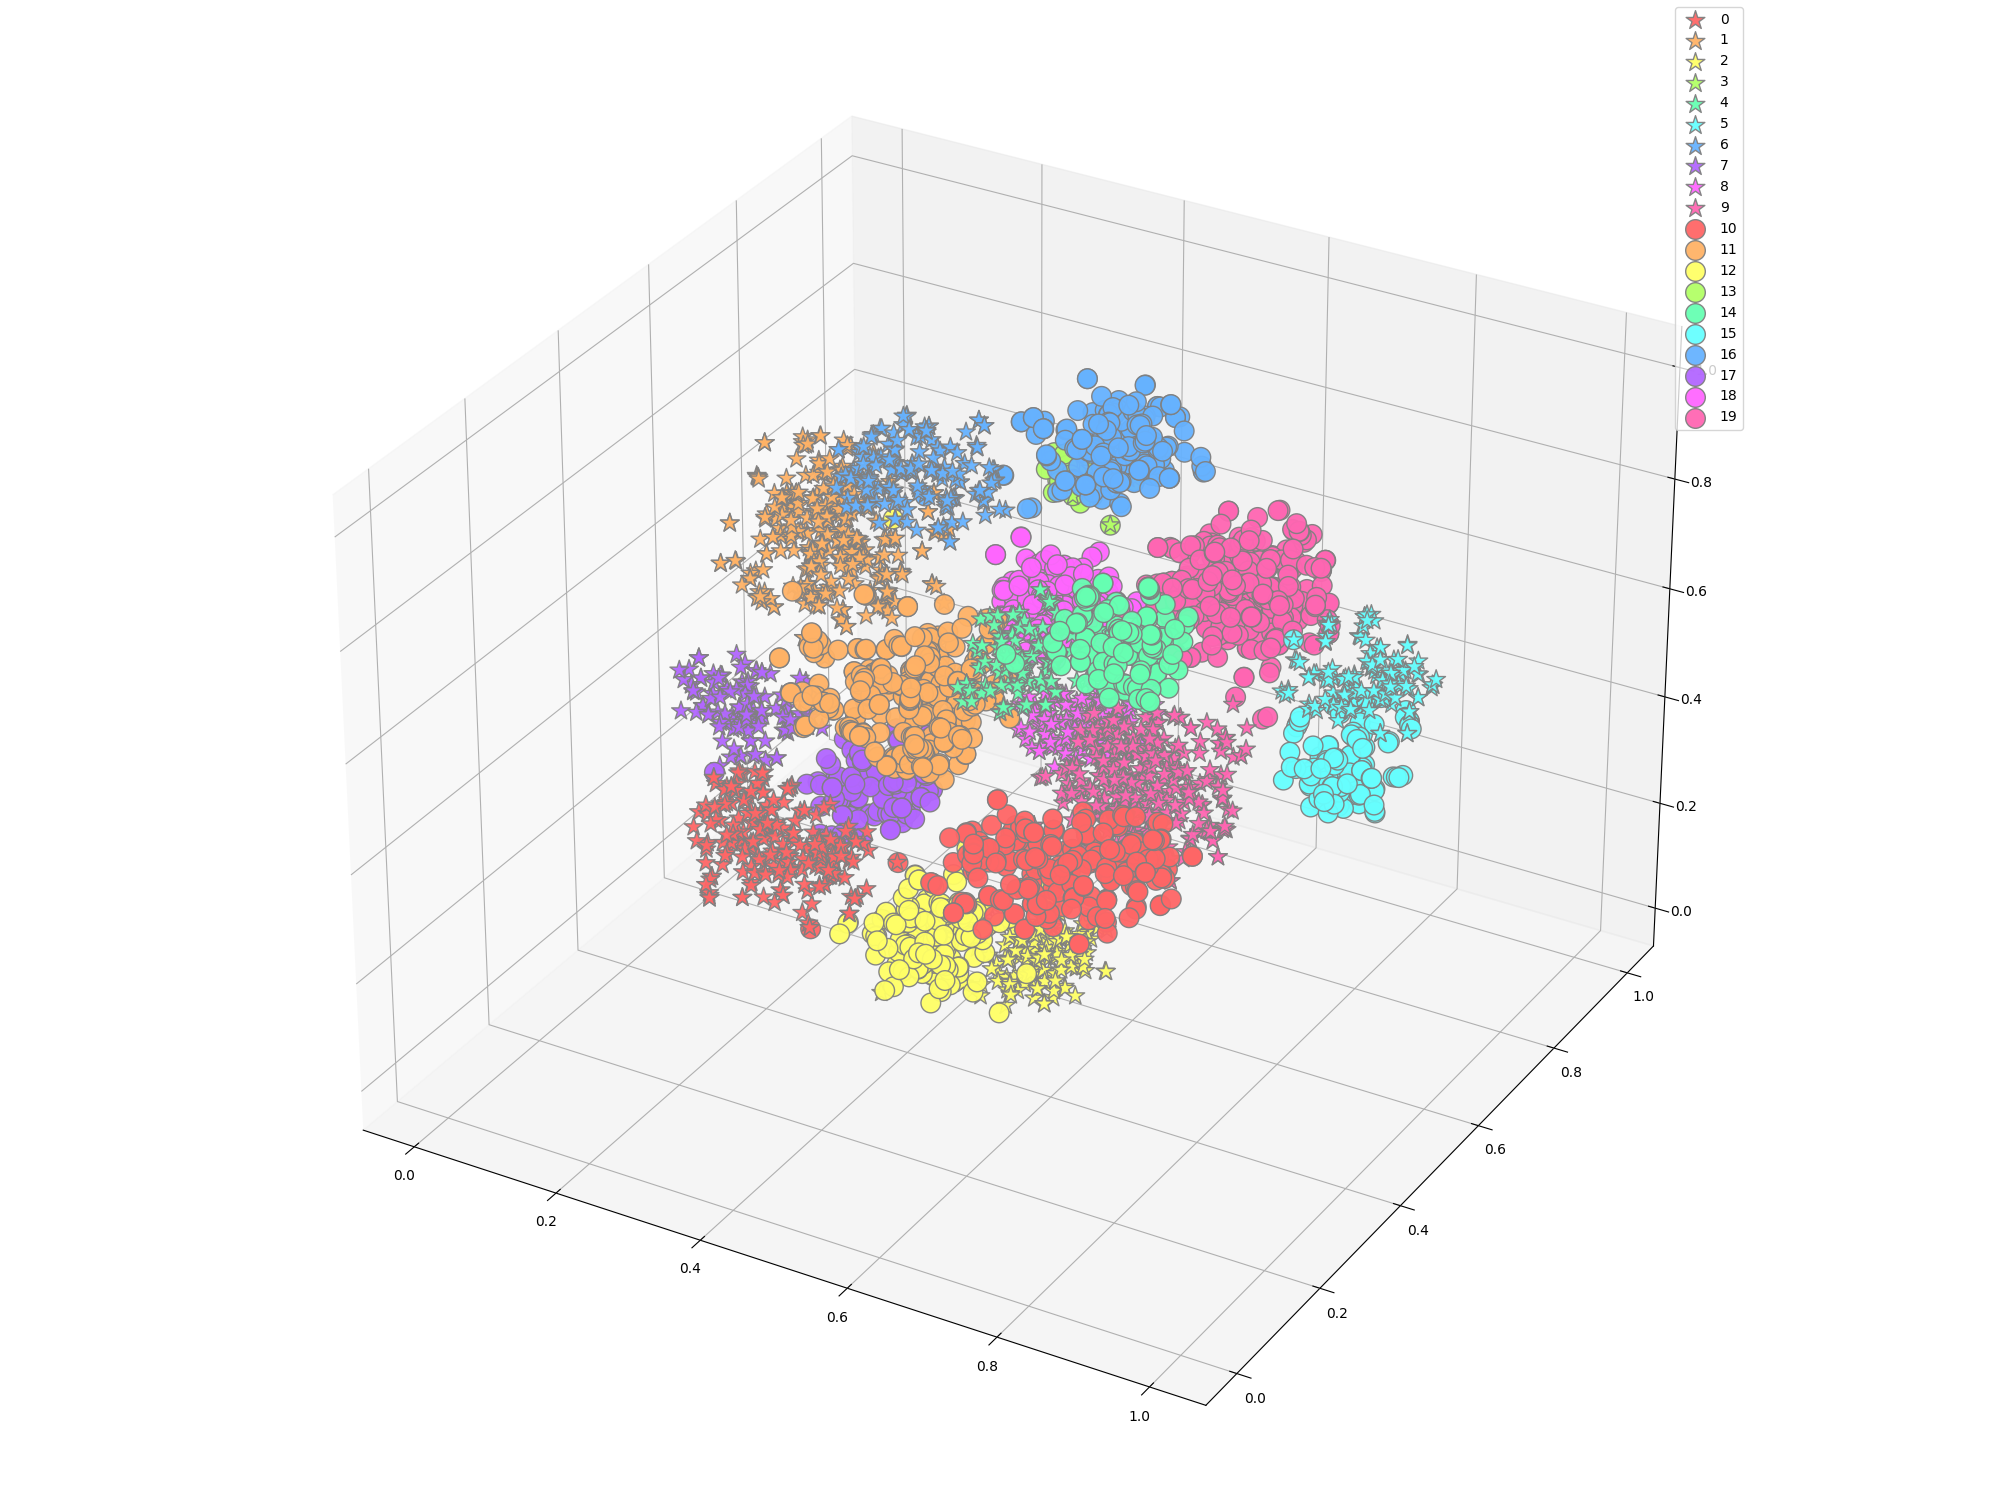

In [ ]:
colors_per_class = {   # B, G, R
    0 : [0, 0, 153],  #red
    1 : [0,76,153],   #orange,brown
    2 : [0,153,153],   #yellow
    3 : [0,153,76],   #olive
    4 : [76,153,0],        #green
    5 : [153,153,0],     #cyan
    6 : [204,102,0],    #blue
    7 : [204,0,102],    #purple
    8 : [204,0,204],  #pink
    9 : [76,0,153],   #rose
    # 10 : [64,64,64],  #grey
    10: [102,102,255],
    11: [102,178,255],
    12: [102,255,255],
    13: [102,255,178],
    14: [178,255,102],
    15: [255,255,102],
    16: [255,178,102],
    17: [255,102,178],
    18: [255,102,255],
    19: [178,102,255],
    # 21: [192,192,192]
    }

colors_per_class = {   # B, G, R
    0: [102,102,255],
    1: [102,178,255],
    2: [102,255,255],
    3: [102,255,178],
    4: [178,255,102],
    5: [255,255,102],
    6: [255,178,102],
    7: [255,102,178],
    8: [255,102,255],
    9: [178,102,255],
    # 10 : [64,64,64],  #grey
    10: [102,102,255],
    11: [102,178,255],
    12: [102,255,255],
    13: [102,255,178],
    14: [178,255,102],
    15: [255,255,102],
    16: [255,178,102],
    17: [255,102,178],
    18: [255,102,255],
    19: [178,102,255],
    # 21: [192,192,192]
    }


marker_per_class = {   
    0 : "*",  
    1 : "*",  
    2 : "*",
    3 : "*",
    4 : "*",
    5 : "*",
    6 : "*",
    7 : "*",
    8 : "*",
    9 : "*",

    10: "o",
    11: "o",
    12: "o",
    13: "o",
    14: "o",
    15: "o",
    16: "o",
    17: "o",
    18: "o",
    19: "o",
    # 20: "o",
    # 21: "o",
    }

image_paths = '/home/tiongsik/PycharmProjects/ideanet_cb/graphs/tsne/baseline_peri_per_class.svg'
visualize_tsne(tsne, image_paths, labels, colors_per_class, marker_per_class, visualization="per_class_visual")